In [1]:

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torchvision.models import resnet50
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

import torch.nn.functional as F
from torchvision import transforms
import cv2
from PIL import Image

from torch.optim import AdamW

import matplotlib.pyplot as plt
import seaborn as sns

from enum import Enum

import os
import random
import functools


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
proj_path = '.'
data_path = f'{proj_path}/MURA-v1.1'

# Load Dataset

In [5]:
# ALL Data
X_train = pd.read_csv(f'{data_path}/train_image_paths.csv', header=None, names=['filePath'])
y_train = pd.read_csv(f'{data_path}/train_labeled_studies.csv', names=['patientDir', 'label'])

X_test = pd.read_csv(f'{data_path}/valid_image_paths.csv', header=None, names=['filePath'])
y_test = pd.read_csv(f'{data_path}/valid_labeled_studies.csv', names=['patientDir', 'label'])

In [6]:
X_train.shape

(36808, 1)

In [5]:
X_train.head()

,filePath
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...


In [8]:
X_train[:3]

,filePath
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...


The label is for a patient. (for all is XRays)

In [9]:
y_train.iloc[0, 0]

'MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/'

In [10]:
y_train.iloc[:, 0]


0        MURA-v1.1/train/XR_SHOULDER/patient00001/study...
1        MURA-v1.1/train/XR_SHOULDER/patient00002/study...
2        MURA-v1.1/train/XR_SHOULDER/patient00003/study...
3        MURA-v1.1/train/XR_SHOULDER/patient00004/study...
4        MURA-v1.1/train/XR_SHOULDER/patient00005/study...
                               ...                        
13452    MURA-v1.1/train/XR_HAND/patient11180/study1_ne...
13453    MURA-v1.1/train/XR_HAND/patient11181/study1_ne...
13454    MURA-v1.1/train/XR_HAND/patient11182/study1_ne...
13455    MURA-v1.1/train/XR_HAND/patient11183/study1_ne...
13456    MURA-v1.1/train/XR_HAND/patient11184/study1_ne...
Name: patientDir, Length: 13457, dtype: object

# Dataset description

In [8]:
print(f"# of patients: {y_train.shape[0]}")
print(f"# samples/ X-rays: {X_train.shape[0]}")
print()

labels, counts = np.unique(y_train['label'], return_counts=True)
print(f"# labels: {len(labels)}")
print(f"Non-fraction: {labels[0]}; Fraction Label: {labels[1]}")
print()

print(f"# patient with fraction: {counts[1]}")
print(f"# patient withOUT fraction: {counts[0]}")
print()

print(f"Proposion of positive (patients with fraction): {counts[1] / y_train.shape[0]:.3f}")


# of patients: 13457
# samples/ X-rays: 36808

# labels: 2
Non-fraction: 0; Fraction Label: 1

# patient with fraction: 5177
# patient withOUT fraction: 8280

Proposion of positive (patients with fraction): 0.385


In [12]:
np.unique(y_train['label'], return_counts=True)

(array([0, 1]), array([8280, 5177]))

In [9]:
def show_xr(xr_path):
    xr = cv2.imread(xr_path)
    plt.imshow(xr)
    plt.show()

def show_patient_images(patient_dir):
    path_to_patient = f'{proj_path}/{patient_dir}'
    xrs = os.listdir(path_to_patient)

    for xr in xrs:
        print(xr)
        show_xr(f'{path_to_patient}/{xr}')

#### Patient 1

image1.png


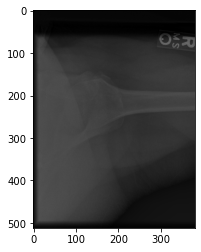

image2.png


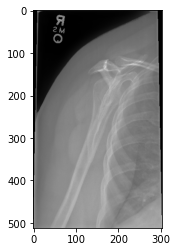

image3.png


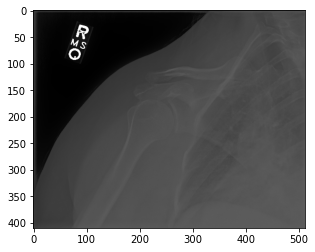

In [11]:
show_patient_images(y_train['patientDir'][0])

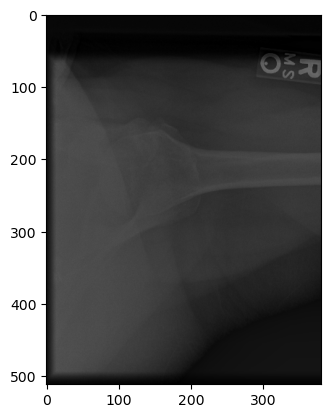

In [15]:
show_xr(X_train['filePath'][0])

In [8]:
def get_client_data(patient_path: str):
    res = []
    xr_names = os.listdir(patient_path)

    for xr in xr_names:
        xr_data = cv2.imread(f'{patient_path}/{xr}')
        res.append(xr_data)

    return res

# Preparation

In [17]:
type(X_train)

pandas.core.frame.DataFrame

In [6]:
X_train['Label'] = X_train['filePath'].apply(lambda x:1 if 'positive' in x else 0)
X_train['BodyPart'] = X_train['filePath'].apply(lambda x: x.split('/')[2][3:])
X_train['StudyType'] = X_train['filePath'].apply(lambda x: x.split('/')[4][:6])

X_test['Label'] = X_test['filePath'].apply(lambda x:1 if 'positive' in x else 0)
X_test['BodyPart'] = X_test['filePath'].apply(lambda x: x.split('/')[2][3:])
X_test['StudyType'] = X_test['filePath'].apply(lambda x: x.split('/')[4][:6])

X_train.set_index(["filePath", "BodyPart"]).count(level="BodyPart")
X_train.set_index(["filePath", "Label"]).count(level="Label")

,BodyPart,StudyType
Label,,
0,21935,21935
1,14873,14873


In [39]:
X_train.head()

,filePath,Label,BodyPart,StudyType
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1,SHOULDER,study1
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1,SHOULDER,study1
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1,SHOULDER,study1
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1,SHOULDER,study1
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1,SHOULDER,study1


In [20]:
np.unique(X_train['BodyPart'], return_counts=True)

(array(['ELBOW', 'FINGER', 'FOREARM', 'HAND', 'HUMERUS', 'SHOULDER',
        'WRIST'], dtype=object),
 array([4931, 5106, 1825, 5543, 1272, 8379, 9752]))

In [31]:
df_part = X_train[X_train['BodyPart'] == 'HAND']
df_fraction = df_part[df_part['Label'] == 1]
df_normal = df_part[df_part['Label'] == 0]

fraction_sample = df_fraction.sample(1)

In [53]:
def compare_normal_and_abnormal(body_parts):
    images = {}
    fig, ax = plt.subplots(len(body_parts), 2, figsize=(8, 12))

    for i, body_part in enumerate(body_parts):
        df_part = X_train[X_train['BodyPart'] == body_part]
        fraction_sample = df_part[df_part['Label'] == 1].sample(1)
        normal_sample = df_part[df_part['Label'] == 0].sample(1)
        
        fraction_image_path = fraction_sample['filePath'].values[0]
        normal_image_path = normal_sample['filePath'].values[0]
        images[body_part] = (fraction_image_path, normal_image_path)
    
        ax[i, 0].imshow(cv2.imread(f'{proj_path}/{images[body_part][0]}'))
        ax[i, 0].set_title(f'Abnormal (Fraction)')
        ax[i, 0].set_xticks([])
        ax[i, 0].set_yticks([])
        ax[i, 1].imshow(cv2.imread(f'{proj_path}/{images[body_part][1]}'))
        ax[i, 1].set_title(f'Normal - {body_part}')
        ax[i, 1].set_xticks([])
        ax[i, 1].set_yticks([])
    plt.show()

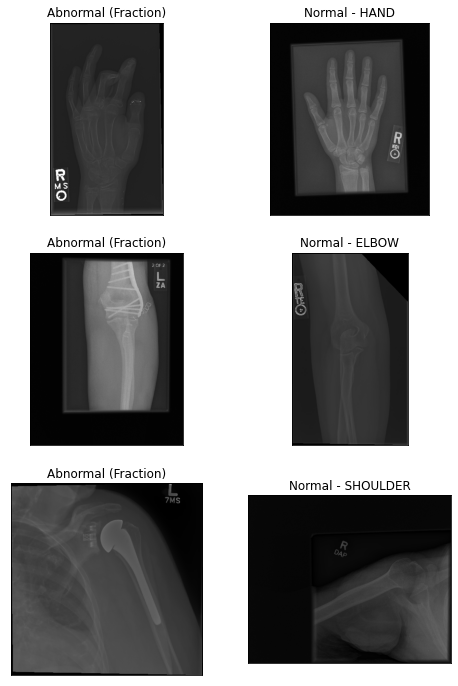

In [54]:
compare_normal_and_abnormal(['HAND', 'ELBOW', 'SHOULDER'])

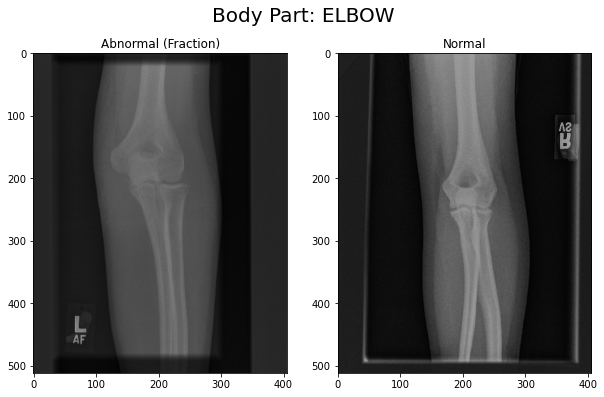

In [20]:
compare_normal_and_abnormal('ELBOW')

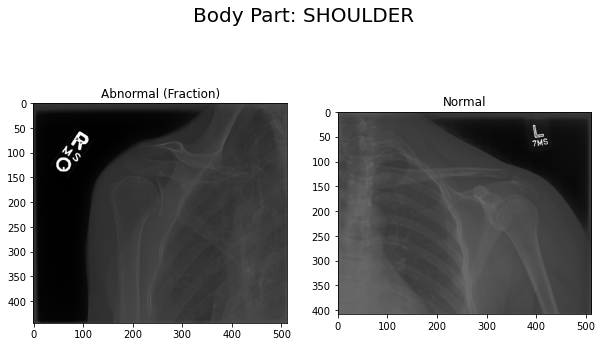

In [22]:
compare_normal_and_abnormal('SHOULDER')

# Focus on Shoulder, Hand and Elbow

In [7]:
class BodyPart(Enum):
    ELBOW = 0
    HAND = 1
    SHOULDER = 2 
    FINGER = 3
    FOREARM = 4
    HUMERUS = 5
    WRIST = 6

    def __eq__(self, other: str):
        return self.value == other

In [9]:
'HAND' == BodyPart.HAND.name

True

In [10]:
focused_body_parts = [BodyPart.ELBOW.name, BodyPart.SHOULDER.name, BodyPart.HAND.name]

X_train_focused = X_train[X_train['BodyPart'].isin(focused_body_parts)].reset_index(drop=True)
X_test_focused = X_test[X_test['BodyPart'].isin(focused_body_parts)].reset_index(drop=True)

In [11]:
X_train_focused['BodyPartLabel'] = X_train_focused['BodyPart'].apply(lambda x: BodyPart[x].value)

In [12]:
X_train_focused.head()

,filePath,Label,BodyPart,StudyType,BodyPartLabel
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1,SHOULDER,study1,2
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1,SHOULDER,study1,2
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1,SHOULDER,study1,2
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1,SHOULDER,study1,2
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1,SHOULDER,study1,2


In [13]:
X_train_focused.set_index(["filePath", "BodyPart"]).count(level="BodyPart")
X_train_focused.set_index(["filePath", "Label"]).count(level="Label")

,BodyPart,StudyType,BodyPartLabel
Label,,,
0,11195,11195,11195
1,7658,7658,7658


In [64]:
print(X_train.shape)
print(X_train_focused.shape)

(36808, 4)
(18853, 4)


In [25]:
print(X_test.shape)
print(X_test_focused.shape)

(3197, 4)
(1488, 4)


# Distribution

In [26]:
np.unique(X_train['BodyPart'], return_counts=True)

(array(['ELBOW', 'FINGER', 'FOREARM', 'HAND', 'HUMERUS', 'SHOULDER',
        'WRIST'], dtype=object),
 array([4931, 5106, 1825, 5543, 1272, 8379, 9752]))

Train data:


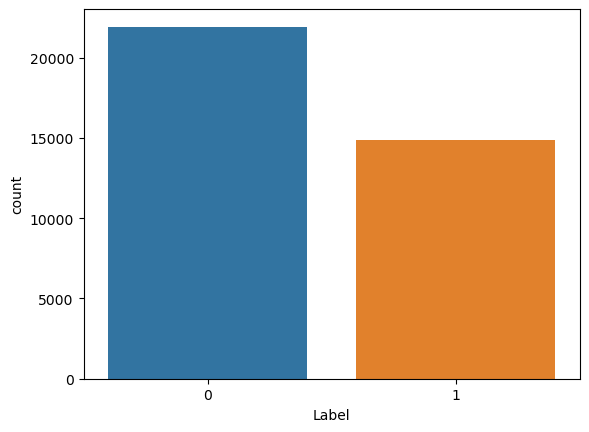

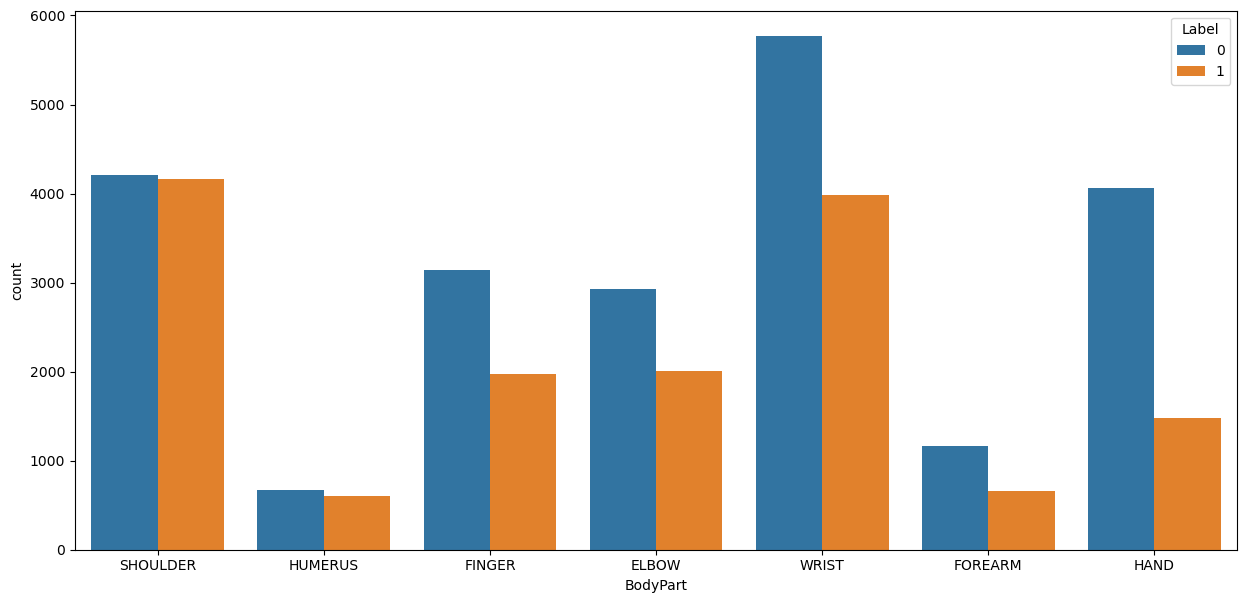

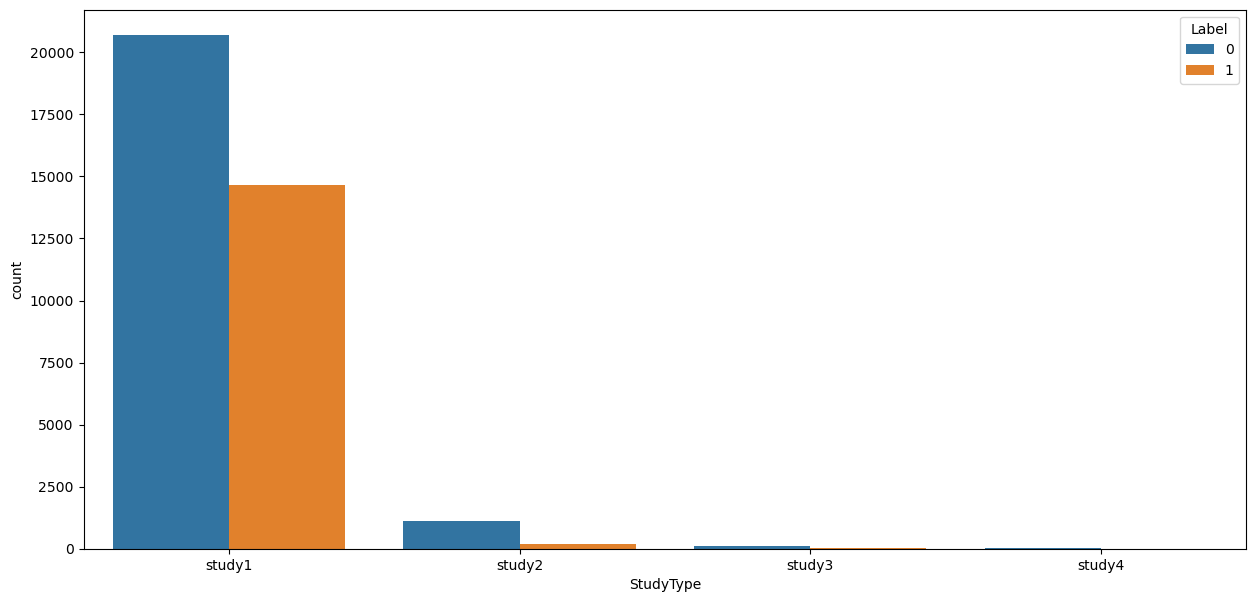

In [15]:
# Train
print('Train data:')
sns.countplot(data=X_train, x='Label')
plt.figure(figsize=(15,7))
sns.countplot(data=X_train,x='BodyPart',hue='Label')
plt.figure(figsize=(15,7))
_ = sns.countplot(data=X_train,x='StudyType',hue='Label')

Validation Data:


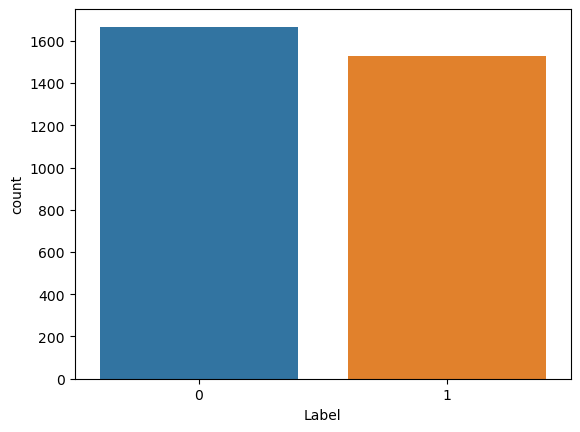

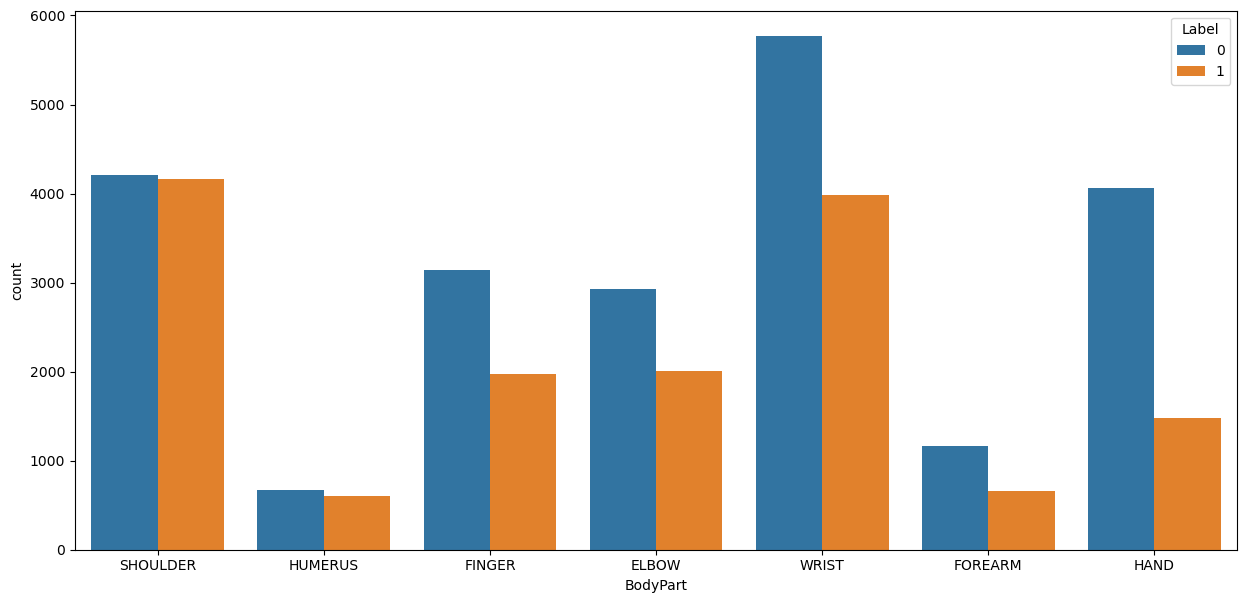

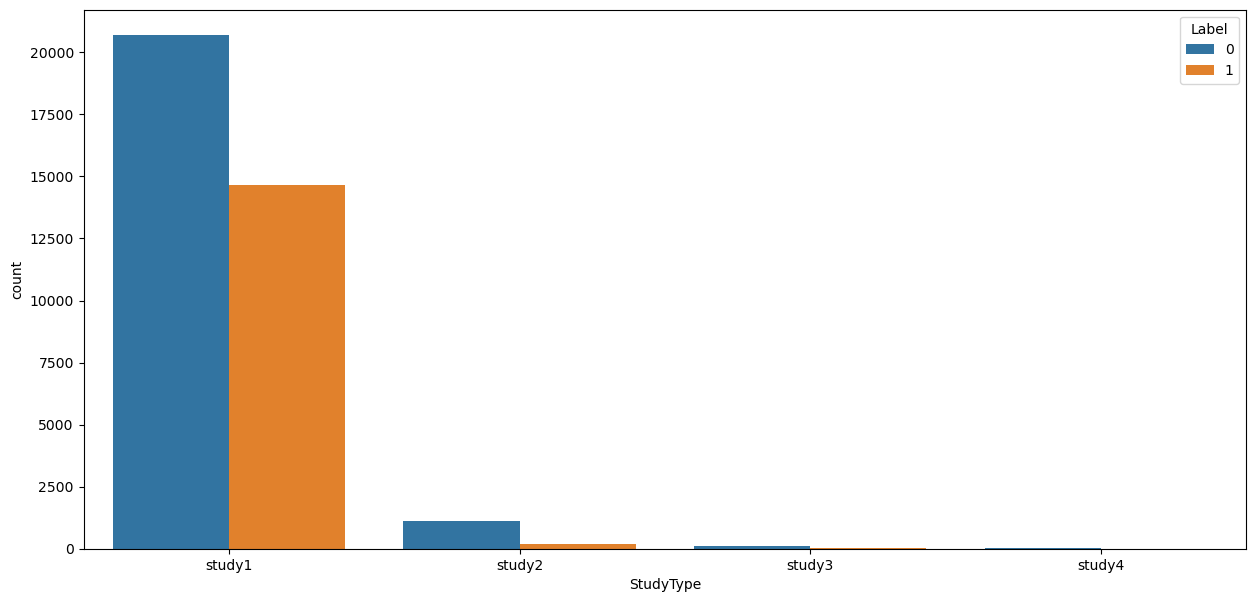

In [16]:
# Test
print('Validation Data:')
sns.countplot(data=X_test, x='Label')
plt.figure(figsize=(15,7))
sns.countplot(data=X_train,x='BodyPart',hue='Label')
plt.figure(figsize=(15,7))
_ = sns.countplot(data=X_train,x='StudyType',hue='Label')

# Dataset

In [14]:
# Augmentation
height, width = 224, 224
simclr_transform_train = transforms.Compose([
    transforms.RandomResizedCrop((height, width)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
    transforms.RandomGrayscale(p=0.1),
    transforms.GaussianBlur(5, sigma=(0.1, 2.0)),
    transforms.Lambda(lambda image: image.convert('RGB')),
    transforms.ToTensor(),
])

simclr_transform_test = transforms.Compose([
    transforms.CenterCrop((height, width)),
    transforms.Resize((height, width)),
    transforms.Lambda(lambda image: image.convert('RGB')),
    transforms.ToTensor(),
])


default_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.GaussianBlur(5, sigma=(0.1, 2.0)),
    transforms.Lambda(lambda image: image.convert('RGB')),
    transforms.ToTensor(),
])

In [19]:
class SimCLRAugmentedDataset(Dataset):
    def __init__(self, dataset, transform, return_original=False):
        self.dataset = dataset
        self.transform = transform
        self.return_original = return_original
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self,idx):
        # I can remove the label
        img_name=self.dataset.iloc[idx,0]
        img = Image.open(f'{proj_path}/{img_name}')

        label=self.dataset.iloc[idx,1]
        img1 = self.transform(img)
        img2 = self.transform(img)
        label = torch.from_numpy(np.asarray(label)).double().type(torch.FloatTensor)
        
        if self.return_original: # for manual inspection
            img = self.transform(img)
            return img, img1, img2, label
        
        return img1, img2, label

In [15]:
def nt_xent_loss(features1, features2, temperature):
    """
    Implements the NT-Xent (Normalized Temperature-Scaled Cross Entropy Loss)
    Args:
        features_i, features_j: the features from the last layer of the neural network for two augmented versions of the same image.
        temperature: temperature scaling parameter.
        device: the device on which tensors should be allocated.
    Returns:
        The NT-Xent Loss.
    """
    batch_size = features1.shape[0]

    # normalize the input features
    features1 = F.normalize(features1, dim=1)
    features2 = F.normalize(features2, dim=1)

    # Concatenate the features from both views
    features = torch.cat([features1, features2], dim=0)

    # Compute similarity matrix
    similarity_matrix = torch.mm(features, features.T)
    # Scale the similarity_matrix by temperature
    similarity_matrix /= temperature

    # Create target matrix
    mask = torch.eye(2 * batch_size, dtype=torch.bool, device=device)

    # positives are the similarity scores on the diagonal
    positives = similarity_matrix[mask].view(2 * batch_size, 1)
    # negatives are the similarity scores off the diagonal
    negatives = similarity_matrix[~mask].view(2 * batch_size, batch_size * 2 - 1)

    # Concatenate and calculate cross entropy loss
    logits = torch.cat([positives, negatives], dim=1)
    labels = torch.zeros(2 * batch_size, dtype=torch.long, device=device)
    loss = F.cross_entropy(logits, labels)
    
    return loss


In [19]:
class SimCLR(nn.Module):
    def __init__(self, feature_dim=128):
        super(SimCLR, self).__init__()
        
        # Use the ResNet model except the last layer (fc)
        self.f = nn.Sequential(*list(resnet50(pretrained=False).children())[:-1])
        
        # Projection head
        self.g = nn.Sequential(
            nn.Linear(2048, 512, bias=False),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Linear(512, feature_dim, bias=True)
        )

        # Define Optimizer - combine the parameters of the two parts of the model
        parameters = list(self.f.parameters()) + list(self.g.parameters())
        self.optimizer = AdamW(parameters, lr=0.001, weight_decay=0.01)

        self.cross_entropy = nn.CrossEntropyLoss().to(device)

    def forward(self, x):
        x = self.f(x)
        representation = torch.flatten(x, start_dim=1)
        out = self.g(representation)
        return out, representation

    def criterion(self, feat1, feat2, temperature):
        return nt_xent_loss(feat1, feat2, temperature)
    
    def train_loop(self, train_dataloader, num_epochs):
        loss_lst = []
        for epoch in tqdm(range(num_epochs)):
            running_loss = 0.0
            for images1, images2, labels in train_dataloader:
                images1, images2, labels = images1.to(device), images2.to(device), labels.to(device)
                self.optimizer.zero_grad()
                feature1, representation1 = self.forward(images1)
                feature2, representation2= self.forward(images2)

                # Calculate the loss
                loss = self.criterion(feature1, feature2, temperature=0.08)
                running_loss += loss.item()
                # Back-propagation and optimization
                loss.backward()
                self.optimizer.step()
                
            epoch_loss = running_loss / len(train_dataloader)
            loss_lst.append(epoch_loss)
            print(f"Epoch {epoch+1} - Loss: {epoch_loss}")


        return loss_lst


In [68]:
# Create the augmented dataset
simclr_train_set = SimCLRAugmentedDataset(X_train_focused, simclr_transform_train)
simclr_train_dataloader = DataLoader(dataset=simclr_train_set, batch_size=64, shuffle=True)

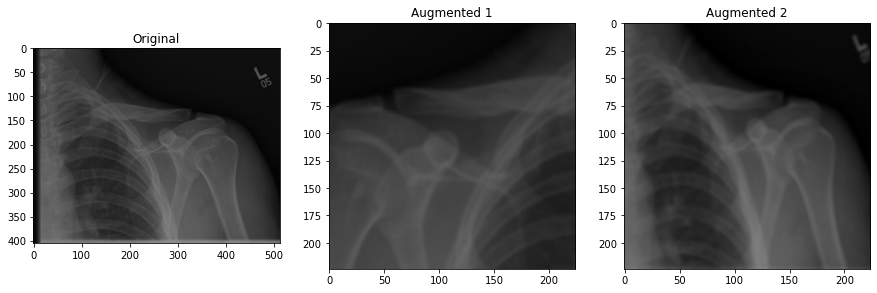

: 

In [83]:
simclr_train_set_inspect = SimCLRAugmentedDataset(X_train_focused, simclr_transform_train, return_original=True)

# Plot the augmented images
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
ax[0].set_title('Original')
ax[0].imshow(simclr_train_set_inspect[1054][0])
ax[1].set_title('Augmented 1')
ax[1].imshow(simclr_train_set_inspect[1054][1].numpy().transpose(1,2,0))
ax[2].set_title('Augmented 2')
ax[2].imshow(simclr_train_set_inspect[1054][2].numpy().transpose(1,2,0))
plt.show()

In [36]:
# choose number of epoches (they used 60)
num_epochs_lst = [2, 4]
model_losses_lst = []

for num_epochs in num_epochs_lst:
    model = SimCLR().to(device)
    hist_losses = model.train_loop(simclr_train_dataloader, num_epochs)
    model_losses_lst.append(hist_losses)
    torch.save(model.state_dict(), f'./pretrained-simclr-models/model_{num_epochs}e')

 50%|██████████████████████                      | 1/2 [05:46<05:46, 346.77s/it]

Epoch 1 - Loss: 0.06102524860604208


100%|████████████████████████████████████████████| 2/2 [11:30<00:00, 345.36s/it]

Epoch 2 - Loss: 0.004472360118308057



 25%|███████████                                 | 1/4 [05:49<17:28, 349.63s/it]

Epoch 1 - Loss: 0.0723286542110145


 50%|██████████████████████                      | 2/4 [11:40<11:40, 350.25s/it]

Epoch 2 - Loss: 0.005680867529995108


 75%|█████████████████████████████████           | 3/4 [17:30<05:50, 350.04s/it]

Epoch 3 - Loss: 0.0030201791927723562


100%|████████████████████████████████████████████| 4/4 [23:20<00:00, 350.08s/it]

Epoch 4 - Loss: 0.0023262461319849903


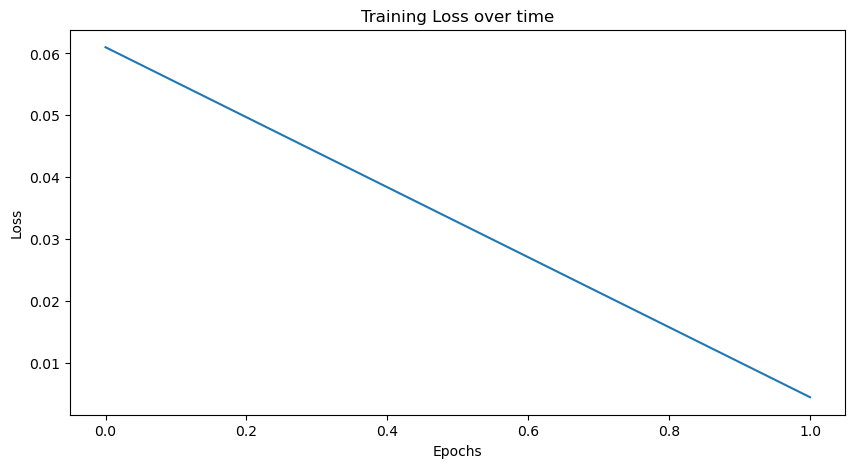

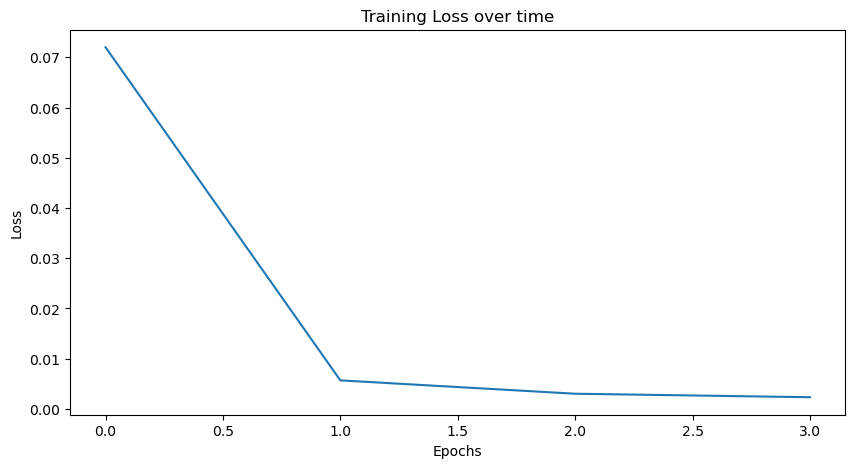

In [40]:
for losses in model_losses_lst:
    # Plotting the losses
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.title('Training Loss over time')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

In [22]:
os.listdir('./pretrained-simclr-models/')

['model_e{num_epochs}', 'model_{num_epochs}e']

In [16]:
X_train_focused

,filePath,Label,BodyPart,StudyType,BodyPartLabel
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1,SHOULDER,study1,2
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1,SHOULDER,study1,2
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1,SHOULDER,study1,2
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1,SHOULDER,study1,2
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1,SHOULDER,study1,2
...,...,...,...,...,...
18848,MURA-v1.1/train/XR_HAND/patient11183/study1_ne...,0,HAND,study1,1
18849,MURA-v1.1/train/XR_HAND/patient11183/study1_ne...,0,HAND,study1,1
18850,MURA-v1.1/train/XR_HAND/patient11184/study1_ne...,0,HAND,study1,1
18851,MURA-v1.1/train/XR_HAND/patient11184/study1_ne...,0,HAND,study1,1


# Fine tuning

In [24]:
class DefaultDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self,idx):
        img_name=self.dataset['filePath'][idx]
        img = Image.open(img_name)

        label=self.dataset['Label'][idx]
        bodyPartLabel = self.dataset['BodyPartLabel'][idx]

        if self.transform:
            img = self.transform(img)

        return img, bodyPartLabel, label

In [25]:
pretrained_model = SimCLR().to(device)
pretrained_model.load_state_dict(torch.load('./pretrained-simclr-models/model_{num_epochs}e'))

<All keys matched successfully>

In [26]:
class TeacherModel(nn.Module):
    def __init__(self, simclr_model, num_body_parts=3):
        super().__init__()
        # Use the encoder from the SimCLR model
        self.encoder = simclr_model.f
        self.base_model = nn.Sequential(
            nn.Linear(2048, 1024, bias=False),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
        )
        # self.proj = simclr_model.g[:-1]
        self.part_classifier= nn.Sequential(
            nn.Linear(1024, 512, bias=False),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 128, bias=False),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64, bias=False),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Linear(64, num_body_parts, bias=True)
        )

        self.fraction_classifier= nn.Sequential(
            nn.Linear(1024, 512, bias=False),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 128, bias=False),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64, bias=False),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 2, bias=True)
        )

        # Freeze the encoder since memory constraints issues
        self.encoder.requires_grad_(False)

        parameters = list(self.part_classifier.parameters())+list(self.fraction_classifier.parameters())
        self.optimizer = AdamW(parameters, lr=0.001, weight_decay=0.01)

        self.cross_entropy = nn.CrossEntropyLoss().to(device)

    def forward(self, x):
        x = self.encoder(x)
        # x = self.proj(x)
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        x = self.base_model(x)
        x_body_part = self.part_classifier(x)
        x_fraction = self.fraction_classifier(x)
        return x_body_part, x_fraction
    
    def train_loop(self, train_dataloader, num_epochs):
        loss_lst = []
        for epoch in tqdm(range(num_epochs)):
            running_loss = 0.0
            for images, bodyParts, labels in train_dataloader:
                images, bodyParts, labels = images.to(device), bodyParts.to(device), labels.to(device) #.long()
                self.optimizer.zero_grad()
                out_body_parts, out_fractions = self.forward(images)
                loss_body_parts = self.cross_entropy(out_body_parts, bodyParts)
                loss_fractions = self.cross_entropy(out_fractions, labels)

                loss = loss_body_parts + loss_fractions
                running_loss += loss.item()
                loss.backward()
                self.optimizer.step()
                
            epoch_loss = running_loss / len(train_dataloader)
            loss_lst.append(epoch_loss)
            print(f"Epoch {epoch+1} - Loss: {epoch_loss}")

        return loss_lst    

In [27]:
def get_x_percent_of_data(x):
    # Get x% of each body part in the training data
    selected_data = []
    for body_part in focused_body_parts:
        df_body_part = X_train_focused[X_train_focused['BodyPart'] == body_part]
        num_to_select = int(len(df_body_part) * x)
        df_body_part = df_body_part.sample(n=num_to_select)
        selected_data.append(df_body_part)
    
    return pd.concat(selected_data).reset_index(drop=True)

In [28]:
finetune_data100 = X_train_focused
finetune_data10 = get_x_percent_of_data(0.1)
finetune_data1 = get_x_percent_of_data(0.01)
model_names = ['1', '10', '100']
num_epochs = [60, 40, 30]
datasets = [finetune_data1, finetune_data10, finetune_data100] 
for i, dataset in enumerate(datasets):
    curr_data = DefaultDataset(dataset, default_transform)
    dataloader = DataLoader(dataset=curr_data, batch_size=64, shuffle=True)
    teacher_model = TeacherModel(pretrained_model).to(device)
    hist_losses = teacher_model.train_loop(dataloader, num_epochs[i])
    torch.save(teacher_model.state_dict(), f'./fined-tuned-models/model_{model_names[i]}')

  2%|▌                                | 1/60 [00:02<02:36,  2.65s/it]

Epoch 1 - Loss: 1.7875362634658813


  3%|█                                | 2/60 [00:04<01:52,  1.94s/it]

Epoch 2 - Loss: 1.3492552439371746


  5%|█▋                               | 3/60 [00:06<02:06,  2.21s/it]

Epoch 3 - Loss: 1.3127360741297405


  7%|██▏                              | 4/60 [00:08<01:48,  1.93s/it]

Epoch 4 - Loss: 1.1437991857528687


  8%|██▊                              | 5/60 [00:09<01:39,  1.81s/it]

Epoch 5 - Loss: 1.090169072151184


 10%|███▎                             | 6/60 [00:11<01:40,  1.85s/it]

Epoch 6 - Loss: 0.9456335306167603


 12%|███▊                             | 7/60 [00:13<01:43,  1.95s/it]

Epoch 7 - Loss: 0.8173004190127054


 13%|████▍                            | 8/60 [00:15<01:36,  1.86s/it]

Epoch 8 - Loss: 0.9192543625831604


 15%|████▉                            | 9/60 [00:16<01:29,  1.75s/it]

Epoch 9 - Loss: 0.7660369078318278


 17%|█████▎                          | 10/60 [00:19<01:38,  1.97s/it]

Epoch 10 - Loss: 0.703205386797587


 18%|█████▊                          | 11/60 [00:21<01:32,  1.89s/it]

Epoch 11 - Loss: 0.8369361162185669


 20%|██████▍                         | 12/60 [00:22<01:24,  1.76s/it]

Epoch 12 - Loss: 0.6021690964698792


 22%|██████▉                         | 13/60 [00:24<01:30,  1.92s/it]

Epoch 13 - Loss: 0.8089519341786703


 23%|███████▍                        | 14/60 [00:26<01:25,  1.86s/it]

Epoch 14 - Loss: 0.5541253884633383


 25%|████████                        | 15/60 [00:28<01:18,  1.75s/it]

Epoch 15 - Loss: 0.6283199191093445


 27%|████████▌                       | 16/60 [00:29<01:15,  1.71s/it]

Epoch 16 - Loss: 0.5659117499987284


 28%|█████████                       | 17/60 [00:32<01:22,  1.91s/it]

Epoch 17 - Loss: 0.5475253065427145


 30%|█████████▌                      | 18/60 [00:33<01:15,  1.80s/it]

Epoch 18 - Loss: 0.4426922599474589


 32%|██████████▏                     | 19/60 [00:35<01:09,  1.71s/it]

Epoch 19 - Loss: 0.43145038684209186


 33%|██████████▋                     | 20/60 [00:37<01:18,  1.97s/it]

Epoch 20 - Loss: 0.465911328792572


 35%|███████████▏                    | 21/60 [00:39<01:12,  1.86s/it]

Epoch 21 - Loss: 0.3945714433987935


 37%|███████████▋                    | 22/60 [00:40<01:06,  1.74s/it]

Epoch 22 - Loss: 0.4411301116148631


 38%|████████████▎                   | 23/60 [00:42<01:03,  1.71s/it]

Epoch 23 - Loss: 0.6572785377502441


 40%|████████████▊                   | 24/60 [00:44<01:09,  1.92s/it]

Epoch 24 - Loss: 0.4033872187137604


 42%|█████████████▎                  | 25/60 [00:46<01:02,  1.79s/it]

Epoch 25 - Loss: 0.6047801375389099


 43%|█████████████▊                  | 26/60 [00:47<00:59,  1.75s/it]

Epoch 26 - Loss: 0.38765062888463336


 45%|██████████████▍                 | 27/60 [00:50<01:03,  1.93s/it]

Epoch 27 - Loss: 0.37907158335049945


 47%|██████████████▉                 | 28/60 [00:51<00:57,  1.79s/it]

Epoch 28 - Loss: 0.4976231058438619


 48%|███████████████▍                | 29/60 [00:53<00:54,  1.75s/it]

Epoch 29 - Loss: 0.2879757583141327


 50%|████████████████                | 30/60 [00:54<00:50,  1.67s/it]

Epoch 30 - Loss: 0.4031554162502289


 52%|████████████████▌               | 31/60 [00:57<00:56,  1.93s/it]

Epoch 31 - Loss: 0.4509682555993398


 53%|█████████████████               | 32/60 [00:58<00:50,  1.80s/it]

Epoch 32 - Loss: 0.3437904268503189


 55%|█████████████████▌              | 33/60 [01:00<00:47,  1.74s/it]

Epoch 33 - Loss: 0.386607567469279


 57%|██████████████████▏             | 34/60 [01:02<00:50,  1.92s/it]

Epoch 34 - Loss: 0.2583519717057546


 58%|██████████████████▋             | 35/60 [01:04<00:44,  1.80s/it]

Epoch 35 - Loss: 0.330441415309906


 60%|███████████████████▏            | 36/60 [01:05<00:40,  1.70s/it]

Epoch 36 - Loss: 0.9098241825898489


 62%|███████████████████▋            | 37/60 [01:07<00:37,  1.63s/it]

Epoch 37 - Loss: 0.3087210754553477


 63%|████████████████████▎           | 38/60 [01:09<00:41,  1.90s/it]

Epoch 38 - Loss: 0.35793845852216083


 65%|████████████████████▊           | 39/60 [01:11<00:37,  1.77s/it]

Epoch 39 - Loss: 0.2413659393787384


 67%|█████████████████████▎          | 40/60 [01:13<00:35,  1.77s/it]

Epoch 40 - Loss: 0.27716995278994244


 68%|█████████████████████▊          | 41/60 [01:15<00:36,  1.94s/it]

Epoch 41 - Loss: 0.473053773244222


 70%|██████████████████████▍         | 42/60 [01:16<00:32,  1.80s/it]

Epoch 42 - Loss: 0.17241988331079483


 72%|██████████████████████▉         | 43/60 [01:18<00:30,  1.77s/it]

Epoch 43 - Loss: 0.3344905475775401


 73%|███████████████████████▍        | 44/60 [01:21<00:32,  2.05s/it]

Epoch 44 - Loss: 0.25770028432210285


 75%|████████████████████████        | 45/60 [01:22<00:28,  1.88s/it]

Epoch 45 - Loss: 0.16954204440116882


 77%|████████████████████████▌       | 46/60 [01:24<00:25,  1.81s/it]

Epoch 46 - Loss: 0.2583571970462799


 78%|█████████████████████████       | 47/60 [01:25<00:22,  1.71s/it]

Epoch 47 - Loss: 0.26735426982243854


 80%|█████████████████████████▌      | 48/60 [01:28<00:22,  1.90s/it]

Epoch 48 - Loss: 0.2365401287873586


 82%|██████████████████████████▏     | 49/60 [01:30<00:20,  1.88s/it]

Epoch 49 - Loss: 0.17098754147688547


 83%|██████████████████████████▋     | 50/60 [01:31<00:17,  1.76s/it]

Epoch 50 - Loss: 0.11593068887790044


 85%|███████████████████████████▏    | 51/60 [01:34<00:17,  1.99s/it]

Epoch 51 - Loss: 0.19320992877086005


 87%|███████████████████████████▋    | 52/60 [01:35<00:14,  1.86s/it]

Epoch 52 - Loss: 0.1560037632783254


 88%|████████████████████████████▎   | 53/60 [01:37<00:12,  1.75s/it]

Epoch 53 - Loss: 0.1998241643110911


 90%|████████████████████████████▊   | 54/60 [01:38<00:10,  1.68s/it]

Epoch 54 - Loss: 0.39108966787656146


 92%|█████████████████████████████▎  | 55/60 [01:41<00:09,  1.91s/it]

Epoch 55 - Loss: 0.18300988525152206


 93%|█████████████████████████████▊  | 56/60 [01:42<00:07,  1.77s/it]

Epoch 56 - Loss: 0.1461535170674324


 95%|██████████████████████████████▍ | 57/60 [01:44<00:05,  1.68s/it]

Epoch 57 - Loss: 0.09654565900564194


 97%|██████████████████████████████▉ | 58/60 [01:46<00:03,  1.97s/it]

Epoch 58 - Loss: 0.10746236890554428


 98%|███████████████████████████████▍| 59/60 [01:48<00:01,  1.81s/it]

Epoch 59 - Loss: 0.25634804119666416


100%|████████████████████████████████| 60/60 [01:49<00:00,  1.83s/it]


Epoch 60 - Loss: 0.14758212367693582


  2%|▊                                | 1/40 [00:19<12:39, 19.47s/it]

Epoch 1 - Loss: 1.506934646765391


  5%|█▋                               | 2/40 [00:38<12:14, 19.33s/it]

Epoch 2 - Loss: 1.3025748173395792


  8%|██▍                              | 3/40 [00:57<11:50, 19.20s/it]

Epoch 3 - Loss: 1.204923446973165


 10%|███▎                             | 4/40 [01:17<11:43, 19.54s/it]

Epoch 4 - Loss: 1.1405237952868144


 12%|████▏                            | 5/40 [01:36<11:16, 19.33s/it]

Epoch 5 - Loss: 1.1649776796499889


 15%|████▉                            | 6/40 [01:55<10:47, 19.04s/it]

Epoch 6 - Loss: 1.1186401585737864


 18%|█████▊                           | 7/40 [02:14<10:25, 18.97s/it]

Epoch 7 - Loss: 1.066695608695348


 20%|██████▌                          | 8/40 [02:32<10:05, 18.91s/it]

Epoch 8 - Loss: 1.0665402154127757


 22%|███████▍                         | 9/40 [02:51<09:45, 18.90s/it]

Epoch 9 - Loss: 1.0580224295457203


 25%|████████                        | 10/40 [03:10<09:26, 18.89s/it]

Epoch 10 - Loss: 1.0201416234175364


 28%|████████▊                       | 11/40 [03:29<09:10, 18.99s/it]

Epoch 11 - Loss: 1.0146914144357047


 30%|█████████▌                      | 12/40 [03:49<08:53, 19.07s/it]

Epoch 12 - Loss: 1.0083340128262839


 32%|██████████▍                     | 13/40 [04:08<08:35, 19.10s/it]

Epoch 13 - Loss: 0.9836321850617726


 35%|███████████▏                    | 14/40 [04:27<08:15, 19.06s/it]

Epoch 14 - Loss: 0.9337904651959738


 38%|████████████                    | 15/40 [04:46<07:58, 19.14s/it]

Epoch 15 - Loss: 1.0015474339326222


 40%|████████████▊                   | 16/40 [05:05<07:38, 19.11s/it]

Epoch 16 - Loss: 0.995544974009196


 42%|█████████████▌                  | 17/40 [05:24<07:16, 18.99s/it]

Epoch 17 - Loss: 0.927073202530543


 45%|██████████████▍                 | 18/40 [05:43<07:00, 19.13s/it]

Epoch 18 - Loss: 0.9625962257385254


 48%|███████████████▏                | 19/40 [06:02<06:39, 19.04s/it]

Epoch 19 - Loss: 0.951860107978185


 50%|████████████████                | 20/40 [06:21<06:20, 19.03s/it]

Epoch 20 - Loss: 0.9102843900521597


 52%|████████████████▊               | 21/40 [06:40<06:02, 19.10s/it]

Epoch 21 - Loss: 0.8811773478984832


 55%|█████████████████▌              | 22/40 [06:59<05:42, 19.04s/it]

Epoch 22 - Loss: 0.8833232343196868


 57%|██████████████████▍             | 23/40 [07:18<05:23, 19.00s/it]

Epoch 23 - Loss: 0.8891265292962393


 60%|███████████████████▏            | 24/40 [07:39<05:12, 19.53s/it]

Epoch 24 - Loss: 0.8899169643719991


 62%|████████████████████            | 25/40 [07:58<04:50, 19.39s/it]

Epoch 25 - Loss: 0.9139676749706268


 65%|████████████████████▊           | 26/40 [08:17<04:29, 19.25s/it]

Epoch 26 - Loss: 0.9195293426513672


 68%|█████████████████████▌          | 27/40 [08:36<04:09, 19.20s/it]

Epoch 27 - Loss: 0.847031815846761


 70%|██████████████████████▍         | 28/40 [08:55<03:50, 19.20s/it]

Epoch 28 - Loss: 0.853084929784139


 72%|███████████████████████▏        | 29/40 [09:14<03:30, 19.17s/it]

Epoch 29 - Loss: 0.8465911606947581


 75%|████████████████████████        | 30/40 [09:34<03:13, 19.30s/it]

Epoch 30 - Loss: 0.8497275133927663


 78%|████████████████████████▊       | 31/40 [09:53<02:52, 19.13s/it]

Epoch 31 - Loss: 0.8006816744804383


 80%|█████████████████████████▌      | 32/40 [10:12<02:33, 19.15s/it]

Epoch 32 - Loss: 0.8218331257502238


 82%|██████████████████████████▍     | 33/40 [10:31<02:13, 19.11s/it]

Epoch 33 - Loss: 0.82469628850619


 85%|███████████████████████████▏    | 34/40 [10:50<01:54, 19.07s/it]

Epoch 34 - Loss: 0.8169173737366994


 88%|████████████████████████████    | 35/40 [11:09<01:35, 19.16s/it]

Epoch 35 - Loss: 0.7962931215763092


 90%|████████████████████████████▊   | 36/40 [11:28<01:16, 19.05s/it]

Epoch 36 - Loss: 0.8497431059678395


 92%|█████████████████████████████▌  | 37/40 [11:48<00:57, 19.21s/it]

Epoch 37 - Loss: 0.7371432701746623


 95%|██████████████████████████████▍ | 38/40 [12:06<00:38, 19.11s/it]

Epoch 38 - Loss: 0.7438815812269847


 98%|███████████████████████████████▏| 39/40 [12:25<00:19, 19.03s/it]

Epoch 39 - Loss: 0.7909198800722758


100%|████████████████████████████████| 40/40 [12:44<00:00, 19.12s/it]


Epoch 40 - Loss: 0.8378257989883423


  3%|█                             | 1/30 [03:07<1:30:34, 187.39s/it]

Epoch 1 - Loss: 1.2301761976743149


  7%|██                            | 2/30 [06:12<1:26:57, 186.34s/it]

Epoch 2 - Loss: 1.0919443577022876


 10%|███                           | 3/30 [09:22<1:24:28, 187.73s/it]

Epoch 3 - Loss: 1.0377661951517654


 13%|████                          | 4/30 [12:31<1:21:35, 188.30s/it]

Epoch 4 - Loss: 1.0024918548131394


 17%|█████                         | 5/30 [15:37<1:18:03, 187.32s/it]

Epoch 5 - Loss: 0.9855801954107769


 20%|██████                        | 6/30 [18:43<1:14:44, 186.84s/it]

Epoch 6 - Loss: 0.969241579710427


 23%|███████                       | 7/30 [21:48<1:11:25, 186.34s/it]

Epoch 7 - Loss: 0.9515012163226887


 27%|████████                      | 8/30 [24:50<1:07:51, 185.06s/it]

Epoch 8 - Loss: 0.9336380908044718


 30%|█████████                     | 9/30 [27:58<1:05:01, 185.77s/it]

Epoch 9 - Loss: 0.9198485505782952


 33%|█████████▋                   | 10/30 [31:02<1:01:45, 185.30s/it]

Epoch 10 - Loss: 0.9138860926789752


 37%|███████████▎                   | 11/30 [34:06<58:34, 184.97s/it]

Epoch 11 - Loss: 0.9041158463995336


 40%|████████████▍                  | 12/30 [37:08<55:10, 183.94s/it]

Epoch 12 - Loss: 0.9026809809571605


 43%|█████████████▍                 | 13/30 [40:09<51:54, 183.21s/it]

Epoch 13 - Loss: 0.8906815197508214


 47%|██████████████▍                | 14/30 [43:15<49:02, 183.89s/it]

Epoch 14 - Loss: 0.877909822585219


 50%|███████████████▌               | 15/30 [46:21<46:09, 184.61s/it]

Epoch 15 - Loss: 0.8841688447079417


 53%|████████████████▌              | 16/30 [49:27<43:11, 185.09s/it]

Epoch 16 - Loss: 0.8705729739140656


 57%|█████████████████▌             | 17/30 [52:32<40:07, 185.17s/it]

Epoch 17 - Loss: 0.8589899778366089


 60%|██████████████████▌            | 18/30 [55:31<36:38, 183.24s/it]

Epoch 18 - Loss: 0.8531114022610551


 63%|███████████████████▋           | 19/30 [58:29<33:18, 181.69s/it]

Epoch 19 - Loss: 0.8638401926574061


 67%|███████████████████▎         | 20/30 [1:01:27<30:05, 180.52s/it]

Epoch 20 - Loss: 0.8508267236968218


 70%|████████████████████▎        | 21/30 [1:04:28<27:04, 180.51s/it]

Epoch 21 - Loss: 0.8478342320959447


 73%|█████████████████████▎       | 22/30 [1:07:28<24:04, 180.57s/it]

Epoch 22 - Loss: 0.8431364150370582


 77%|██████████████████████▏      | 23/30 [1:10:31<21:08, 181.17s/it]

Epoch 23 - Loss: 0.8237737316196247


 80%|███████████████████████▏     | 24/30 [1:13:32<18:07, 181.21s/it]

Epoch 24 - Loss: 0.8355459152641943


 83%|████████████████████████▏    | 25/30 [1:16:36<15:10, 182.17s/it]

Epoch 25 - Loss: 0.8309775685859939


 87%|█████████████████████████▏   | 26/30 [1:19:40<12:10, 182.59s/it]

Epoch 26 - Loss: 0.8169613543203321


 90%|██████████████████████████   | 27/30 [1:22:47<09:11, 183.75s/it]

Epoch 27 - Loss: 0.8194602061126192


 93%|███████████████████████████  | 28/30 [1:25:54<06:09, 184.74s/it]

Epoch 28 - Loss: 0.8174211964768878


 97%|████████████████████████████ | 29/30 [1:29:01<03:05, 185.56s/it]

Epoch 29 - Loss: 0.7988091301109831


100%|█████████████████████████████| 30/30 [1:32:08<00:00, 184.28s/it]

Epoch 30 - Loss: 0.8055347038527666


In [29]:
os.listdir('./fined-tuned-models/')[0]

"model_['1', '10', '100']"

In [30]:
class StudentModel(nn.Module):
    def __init__(self, num_body_parts=3):
        super(StudentModel, self).__init__()
        # Use the ResNet model except the last layer (fc)
        self.resnet = nn.Sequential(*list(resnet50(pretrained=True).children())[:-1])
        self.resnet.requires_grad_(False)

        self.base_model = nn.Sequential(
            nn.Linear(2048, 1024, bias=False),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
        )

        self.part_classifier= nn.Sequential(
            nn.Linear(1024, 512, bias=False),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 128, bias=False),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64, bias=False),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Linear(64, num_body_parts, bias=True)
        )

        self.fraction_classifier= nn.Sequential(
            nn.Linear(1024, 512, bias=False),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 128, bias=False),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64, bias=False),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 2, bias=True)
        )

        # Define Optimizer - combine the parameters of the two parts of the model
        parameters = list(self.base_model.parameters()) + list(self.fraction_classifier.parameters()) + list(self.part_classifier.parameters())
        self.optimizer = AdamW(parameters, lr=0.001, weight_decay=0.01)
        
        self.criterion = nn.KLDivLoss(reduction='batchmean')  # This loss function is suitable for distillation
        # self.cross_entropy = nn.CrossEntropyLoss().to(device)

    def forward(self, x):
        x = self.resnet(x)
        x = torch.flatten(x, start_dim=1)
        x = self.base_model(x)
        x_body_part = self.part_classifier(x)
        x_fraction = self.fraction_classifier(x)
        return x_body_part, x_fraction
    
    def train_loop(self, train_dataloader, num_epochs, teacher):
        teacher.eval()

        loss_lst = []
        for epoch in tqdm(range(num_epochs)):
            running_loss = 0.0
            for images, _, _ in train_dataloader:
                images = images.to(device)

                with torch.no_grad():
                    teacher_outputs_parts, teacher_outputs_fraction = teacher(images)
                    teacher_outputs_parts, teacher_outputs_fraction = F.log_softmax(teacher_outputs_parts, dim=1), F.log_softmax(teacher_outputs_fraction, dim=1)

                # Forward pass of the student
                student_outputs_parts, student_outputs_fraction = self.forward(images)
                student_outputs_parts, student_outputs_fraction = F.log_softmax(student_outputs_parts, dim=1), F.log_softmax(student_outputs_fraction, dim=1)
        
                # Calculate the loss
                loss_body_parts = self.criterion(student_outputs_parts, teacher_outputs_parts)
                loss_fractions = self.criterion(student_outputs_fraction, teacher_outputs_fraction)

                loss = loss_body_parts + loss_fractions
                running_loss += loss.item()
                
                # Backward and optimize
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

            epoch_loss = running_loss / len(train_dataloader)
            loss_lst.append(epoch_loss)
            print(f"Epoch {epoch+1} - Loss: {epoch_loss}")

        return loss_lst


In [78]:
val_data = DefaultDataset(X_test_focused, default_transform)
val_dataloader = DataLoader(dataset=val_data, batch_size=64, shuffle=True)

In [80]:
teacher = TeacherModel(pretrained_model).to(device)
teacher.load_state_dict(torch.load("./fined-tuned-models/model_['1', '10', '100']"))

<All keys matched successfully>

In [81]:
# Make sure the teacher model is in evaluation mode
teacher.eval()

# Initialize counters
total = 0
correct_body_part = 0
correct_fraction = 0

# We don't need gradients for evaluation, so wrap in no_grad to save memory
with torch.no_grad():
    for i, (inputs, labels_body_part, labels_fraction) in enumerate(teacher):
        inputs = inputs.to(device)
        labels_body_part, labels_fraction = labels_body_part.to(device), labels_fraction.to(device)

        # Forward pass and get predictions
        outputs_body_part, outputs_fraction = teacher(inputs)
        _, predicted_body_part = torch.max(outputs_body_part.data, 1)
        _, predicted_fraction = torch.max(outputs_fraction.data, 1)

        # Update counters
        total += labels_body_part.size(0)
        correct_body_part += (predicted_body_part == labels_body_part).sum().item()
        correct_fraction += (predicted_fraction == labels_fraction).sum().item()

# Compute accuracy
accuracy_body_part = correct_body_part / total
accuracy_fraction = correct_fraction / total

print('Accuracy of the teacher model on the validation set:')
print('Body part: {}%'.format(100 * accuracy_body_part))
print('Fraction: {}%'.format(100 * accuracy_fraction))


NameError: name 'val_loader' is not defined

In [31]:
os.mkdir('./student-models/')

In [32]:
model_names = ['1', '10', '100']
model_losses_lst = {}
for model_name in model_names:
    teacher = TeacherModel(pretrained_model).to(device)
    teacher.load_state_dict(torch.load(f'./fined-tuned-models/model_{model_names[i]}'))

    student = StudentModel(3).to(device)

    train_data = DefaultDataset(X_train_focused, default_transform)
    train_dataloader = DataLoader(dataset=curr_data, batch_size=64, shuffle=True)

    hist_losses = student.train_loop(train_dataloader, 30, teacher)
    torch.save(student.state_dict(), f'./student-models//model_{model_names[i]}')

    model_losses_lst[model_name] = hist_losses

  3%|█                             | 1/30 [03:19<1:36:23, 199.45s/it]

Epoch 1 - Loss: nan


  7%|██                            | 2/30 [06:38<1:33:00, 199.30s/it]

Epoch 2 - Loss: nan


 10%|███                           | 3/30 [10:01<1:30:27, 201.00s/it]

Epoch 3 - Loss: nan


 13%|████                          | 4/30 [13:26<1:27:48, 202.62s/it]

Epoch 4 - Loss: nan


 17%|█████                         | 5/30 [16:51<1:24:46, 203.46s/it]

Epoch 5 - Loss: nan


 20%|██████                        | 6/30 [20:15<1:21:22, 203.42s/it]

Epoch 6 - Loss: nan


 23%|███████                       | 7/30 [23:39<1:18:08, 203.84s/it]

Epoch 7 - Loss: nan


 27%|████████                      | 8/30 [27:03<1:14:45, 203.90s/it]

Epoch 8 - Loss: nan


 30%|█████████                     | 9/30 [30:27<1:11:18, 203.76s/it]

Epoch 9 - Loss: nan


 33%|█████████▋                   | 10/30 [33:52<1:08:02, 204.10s/it]

Epoch 10 - Loss: nan


 37%|██████████▋                  | 11/30 [37:16<1:04:41, 204.28s/it]

Epoch 11 - Loss: nan


 40%|███████████▌                 | 12/30 [40:41<1:01:18, 204.38s/it]

Epoch 12 - Loss: nan


 43%|█████████████▍                 | 13/30 [44:06<57:55, 204.45s/it]

Epoch 13 - Loss: nan


 47%|██████████████▍                | 14/30 [47:31<54:33, 204.61s/it]

Epoch 14 - Loss: nan


 50%|███████████████▌               | 15/30 [50:56<51:12, 204.85s/it]

Epoch 15 - Loss: nan


 53%|████████████████▌              | 16/30 [54:22<47:51, 205.08s/it]

Epoch 16 - Loss: nan


 57%|█████████████████▌             | 17/30 [57:46<44:21, 204.75s/it]

Epoch 17 - Loss: nan


 60%|█████████████████▍           | 18/30 [1:01:11<40:58, 204.86s/it]

Epoch 18 - Loss: nan


 63%|██████████████████▎          | 19/30 [1:04:36<37:36, 205.15s/it]

Epoch 19 - Loss: nan


 67%|███████████████████▎         | 20/30 [1:08:01<34:10, 205.01s/it]

Epoch 20 - Loss: nan


 70%|████████████████████▎        | 21/30 [1:11:27<30:47, 205.28s/it]

Epoch 21 - Loss: nan


 73%|█████████████████████▎       | 22/30 [1:14:51<27:19, 204.95s/it]

Epoch 22 - Loss: nan


 77%|██████████████████████▏      | 23/30 [1:18:10<23:41, 203.13s/it]

Epoch 23 - Loss: nan


 80%|███████████████████████▏     | 24/30 [1:21:26<20:05, 200.93s/it]

Epoch 24 - Loss: nan


 83%|████████████████████████▏    | 25/30 [1:24:48<16:46, 201.34s/it]

Epoch 25 - Loss: nan


 87%|█████████████████████████▏   | 26/30 [1:28:12<13:28, 202.04s/it]

Epoch 26 - Loss: nan


 90%|██████████████████████████   | 27/30 [1:31:37<10:08, 202.84s/it]

Epoch 27 - Loss: nan


 93%|███████████████████████████  | 28/30 [1:35:02<06:47, 203.69s/it]

Epoch 28 - Loss: nan


 97%|████████████████████████████ | 29/30 [1:38:28<03:24, 204.23s/it]

Epoch 29 - Loss: nan


100%|█████████████████████████████| 30/30 [1:41:50<00:00, 203.67s/it]

Epoch 30 - Loss: nan



  3%|█                             | 1/30 [03:17<1:35:26, 197.45s/it]

Epoch 1 - Loss: nan


  7%|██                            | 2/30 [06:39<1:33:23, 200.13s/it]

Epoch 2 - Loss: nan


 10%|███                           | 3/30 [10:01<1:30:26, 200.97s/it]

Epoch 3 - Loss: nan


 13%|████                          | 4/30 [13:25<1:27:38, 202.24s/it]

Epoch 4 - Loss: nan


 17%|█████                         | 5/30 [16:47<1:24:13, 202.14s/it]

Epoch 5 - Loss: nan


 20%|██████                        | 6/30 [20:04<1:20:09, 200.41s/it]

Epoch 6 - Loss: nan


 23%|███████                       | 7/30 [23:21<1:16:20, 199.13s/it]

Epoch 7 - Loss: nan


 27%|████████                      | 8/30 [26:36<1:12:37, 198.08s/it]

Epoch 8 - Loss: nan


 30%|█████████                     | 9/30 [29:57<1:09:38, 198.97s/it]

Epoch 9 - Loss: nan


 33%|█████████▋                   | 10/30 [33:18<1:06:29, 199.49s/it]

Epoch 10 - Loss: nan


 37%|██████████▋                  | 11/30 [36:39<1:03:20, 200.01s/it]

Epoch 11 - Loss: nan


 40%|███████████▌                 | 12/30 [40:04<1:00:24, 201.39s/it]

Epoch 12 - Loss: nan


 43%|█████████████▍                 | 13/30 [43:24<56:57, 201.01s/it]

Epoch 13 - Loss: nan


 47%|██████████████▍                | 14/30 [46:49<53:56, 202.28s/it]

Epoch 14 - Loss: nan


 50%|███████████████▌               | 15/30 [50:13<50:43, 202.90s/it]

Epoch 15 - Loss: nan


 53%|████████████████▌              | 16/30 [53:39<47:29, 203.57s/it]

Epoch 16 - Loss: nan


 57%|█████████████████▌             | 17/30 [56:57<43:44, 201.92s/it]

Epoch 17 - Loss: nan


 60%|█████████████████▍           | 18/30 [1:00:16<40:14, 201.24s/it]

Epoch 18 - Loss: nan


 63%|██████████████████▎          | 19/30 [1:03:37<36:52, 201.17s/it]

Epoch 19 - Loss: nan


 67%|███████████████████▎         | 20/30 [1:06:57<33:27, 200.70s/it]

Epoch 20 - Loss: nan


 70%|████████████████████▎        | 21/30 [1:10:19<30:09, 201.02s/it]

Epoch 21 - Loss: nan


 73%|█████████████████████▎       | 22/30 [1:13:40<26:49, 201.18s/it]

Epoch 22 - Loss: nan


 77%|██████████████████████▏      | 23/30 [1:17:00<23:24, 200.61s/it]

Epoch 23 - Loss: nan


 80%|███████████████████████▏     | 24/30 [1:20:20<20:04, 200.68s/it]

Epoch 24 - Loss: nan


 83%|████████████████████████▏    | 25/30 [1:23:43<16:46, 201.30s/it]

Epoch 25 - Loss: nan


 87%|█████████████████████████▏   | 26/30 [1:27:06<13:27, 201.83s/it]

Epoch 26 - Loss: nan


 90%|██████████████████████████   | 27/30 [1:30:31<10:08, 202.82s/it]

Epoch 27 - Loss: nan


 93%|███████████████████████████  | 28/30 [1:33:56<06:46, 203.42s/it]

Epoch 28 - Loss: nan


 97%|████████████████████████████ | 29/30 [1:37:21<03:23, 203.95s/it]

Epoch 29 - Loss: nan


100%|█████████████████████████████| 30/30 [1:40:46<00:00, 201.56s/it]

Epoch 30 - Loss: nan



  3%|█                             | 1/30 [03:21<1:37:25, 201.58s/it]

Epoch 1 - Loss: nan


  7%|██                            | 2/30 [06:43<1:34:16, 202.01s/it]

Epoch 2 - Loss: nan


 10%|███                           | 3/30 [10:08<1:31:21, 203.03s/it]

Epoch 3 - Loss: nan


 13%|████                          | 4/30 [13:33<1:28:17, 203.76s/it]

Epoch 4 - Loss: nan


 17%|█████                         | 5/30 [16:56<1:24:53, 203.73s/it]

Epoch 5 - Loss: nan


 20%|██████                        | 6/30 [20:21<1:21:39, 204.17s/it]

Epoch 6 - Loss: nan


 23%|███████                       | 7/30 [23:46<1:18:18, 204.30s/it]

Epoch 7 - Loss: nan


 27%|████████                      | 8/30 [27:07<1:14:32, 203.29s/it]

Epoch 8 - Loss: nan


 30%|█████████                     | 9/30 [30:48<1:13:06, 208.86s/it]

Epoch 9 - Loss: nan


 33%|█████████▋                   | 10/30 [34:12<1:09:09, 207.45s/it]

Epoch 10 - Loss: nan


 37%|██████████▋                  | 11/30 [37:33<1:05:04, 205.51s/it]

Epoch 11 - Loss: nan


 40%|███████████▌                 | 12/30 [40:55<1:01:16, 204.23s/it]

Epoch 12 - Loss: nan


 43%|█████████████▍                 | 13/30 [44:20<57:57, 204.55s/it]

Epoch 13 - Loss: nan


 47%|██████████████▍                | 14/30 [47:45<54:34, 204.65s/it]

Epoch 14 - Loss: nan


 50%|███████████████▌               | 15/30 [51:04<50:44, 202.99s/it]

Epoch 15 - Loss: nan


 53%|████████████████▌              | 16/30 [54:19<46:49, 200.68s/it]

Epoch 16 - Loss: nan


 57%|█████████████████▌             | 17/30 [57:35<43:08, 199.13s/it]

Epoch 17 - Loss: nan


 60%|█████████████████▍           | 18/30 [1:00:53<39:45, 198.81s/it]

Epoch 18 - Loss: nan


 63%|██████████████████▎          | 19/30 [1:04:16<36:41, 200.10s/it]

Epoch 19 - Loss: nan


 67%|███████████████████▎         | 20/30 [1:07:33<33:10, 199.06s/it]

Epoch 20 - Loss: nan


 70%|████████████████████▎        | 21/30 [1:10:34<29:02, 193.66s/it]

Epoch 21 - Loss: nan


 73%|█████████████████████▎       | 22/30 [1:13:48<25:50, 193.79s/it]

Epoch 22 - Loss: nan


 77%|██████████████████████▏      | 23/30 [1:17:09<22:52, 196.11s/it]

Epoch 23 - Loss: nan


 80%|███████████████████████▏     | 24/30 [1:20:32<19:48, 198.04s/it]

Epoch 24 - Loss: nan


 83%|████████████████████████▏    | 25/30 [1:23:55<16:38, 199.71s/it]

Epoch 25 - Loss: nan


 87%|█████████████████████████▏   | 26/30 [1:27:18<13:21, 200.49s/it]

Epoch 26 - Loss: nan


 90%|██████████████████████████   | 27/30 [1:30:41<10:04, 201.45s/it]

Epoch 27 - Loss: nan


 93%|███████████████████████████  | 28/30 [1:34:05<06:43, 201.98s/it]

Epoch 28 - Loss: nan


 97%|████████████████████████████ | 29/30 [1:37:28<03:22, 202.49s/it]

Epoch 29 - Loss: nan


100%|█████████████████████████████| 30/30 [1:40:51<00:00, 201.71s/it]

Epoch 30 - Loss: nan


In [79]:
teacher = TeacherModel(pretrained_model).to(device)
teacher.load_state_dict(torch.load("./fined-tuned-models/model_['1', '10', '100']"))

# Make sure the teacher model is in evaluation mode
teacher.eval()

# Initialize counters
total = 0
correct = 0

# We don't need gradients for evaluation, so wrap in no_grad to save memory
with torch.no_grad():
    for i, (inputs, labels) in tqdm(enumerate(val_dataloader)):
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass and get predictions
        outputs = teacher(inputs)
        
        _, predicted = torch.max(outputs.data, 1)

        # Update counters
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Compute accuracy
accuracy = correct / total
print('Accuracy of the teacher model on the validation set: {}%'.format(100 * accuracy))


0it [00:00, ?it/s]


AttributeError: 'tuple' object has no attribute 'data'

In [76]:
# Initialize student and teacher models
student = StudentModel(3).to(device)

train_data = DefaultDataset(X_train_focused, default_transform)
train_dataloader = DataLoader(dataset=curr_data, batch_size=64, shuffle=True)
# Make sure the teacher model is in evaluation mode
teacher.eval()


for epoch in range(30):
    for i, (inputs, _) in tqdm(enumerate(train_dataloader)):
        inputs = inputs.to(device)

        # Forward pass of the teacher with no gradient tracking
        with torch.no_grad():
            teacher_outputs_parts, teacher_outputs_fraction = teacher(inputs)
            teacher_outputs_parts, teacher_outputs_fraction = F.log_softmax(teacher_outputs_parts, dim=1), F.log_softmax(teacher_outputs_fraction, dim=1)

        # Forward pass of the student
        student_outputs_parts, student_outputs_fraction = student(inputs)
        student_outputs_parts, student_outputs_fraction = F.log_softmax(student_outputs_parts, dim=1), F.log_softmax(student_outputs_fraction, dim=1)
        
        # Compute the loss
        loss_body_parts = student.criterion(student_outputs_parts, teacher_outputs_parts)
        loss_fractions = student.criterion(student_outputs_fraction, teacher_outputs_fraction)

        loss = loss_body_parts + loss_fractions

        # Backward and optimize
        student.optimizer.zero_grad()
        loss.backward()
        student.optimizer.step()

    print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))


107it [01:03,  1.67it/s]


KeyboardInterrupt: 

In [ ]:
fine_tune_model = FineTuneModel(simclr_model)

# Define your loss function, optimizer, and dataloaders
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(fine_tune_model.parameters())
train_dataloader = DataLoader(YourTrainDataset, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(YourValidDataset, batch_size=32, shuffle=False)

# Training loop
num_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
fine_tune_model = fine_tune_model.to(device)

for epoch in range(num_epochs):
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = fine_tune_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

In [ ]:
# Initialize student and teacher models
student = Student(num_classes).to(device)
teacher = ...  # Your pre-trained teacher model

# Make sure the teacher model is in evaluation mode
teacher.eval()

# Define a loss function and an optimizer
criterion = nn.KLDivLoss(reduction='batchmean')  # This loss function is suitable for distillation
optimizer = torch.optim.Adam(student.parameters())

for epoch in range(num_epochs):
    for i, (inputs, _) in enumerate(train_loader):  # We don't need the true labels
        inputs = inputs.to(device)

        # Forward pass of the teacher with no gradient tracking
        with torch.no_grad():
            teacher_outputs = F.log_softmax(teacher(inputs), dim=1)

        # Forward pass of the student
        student_outputs = F.log_softmax(student(inputs), dim=1)

        # Compute the loss
        loss = criterion(student_outputs, teacher_outputs)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))
